# 1. Data Preprocessing and import libraries

## 1.1 Import required libraries

In [1]:
import numpy as np
from urllib import request
import random
import gzip
import pickle
import os
import matplotlib.pyplot as plt
import pandas as pd 
%matplotlib inline

## 1.2 Load mnist data

In [8]:
filename = [
["training_images","train-images-idx3-ubyte.gz"],
["test_images","t10k-images-idx3-ubyte.gz"],
["training_labels","train-labels-idx1-ubyte.gz"],
["test_labels","t10k-labels-idx1-ubyte.gz"]
]

In [6]:
def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init():
    download_mnist()
    save_mnist()

def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]
init()

Download complete.
Save complete.


In [7]:
def load_mnist(final=False, flatten=True):

    if not os.path.isfile('mnist.pkl'):
        init()

    xtrain, ytrain, xtest, ytest = load()
    xtl, xsl = xtrain.shape[0], xtest.shape[0]

    if flatten:
        xtrain = xtrain.reshape(xtl, -1)
        xtest  = xtest.reshape(xsl, -1)

    if not final: # return the flattened images
        return (xtrain[:-5000], ytrain[:-5000]), (xtrain[-5000:], ytrain[-5000:]), 10

    return (xtrain, ytrain), (xtest, ytest), 10

In [9]:
x_train, t_train, x_test, t_test = load()

In [30]:
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


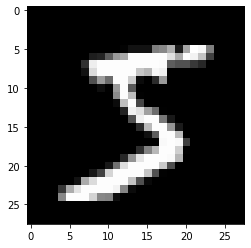

In [10]:
img = x_train[0,:].reshape(28,28) # First image in the training set.
plt.imshow(img,cmap='gray')
plt.show() # Show the image

## 1.3 data processing

### 1.3.1 Cover data to numpy array, convert to float and normalize by deviding 255 as gray sclase images will have 255 as the maximum value

In [15]:
x_train = np.array(x_train)
t_train = np.array(t_train)
x_test = np.array(x_test)
t_test = np.array(t_test)

In [16]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_train = x_train/255.
x_test = x_test/255.

## 1.3.2 Output data processing by converting to one hot encoded data

In [17]:
def convertToOneHot(vector, num_classes=None):

    assert isinstance(vector, np.ndarray)
    assert len(vector) > 0

    if num_classes is None:
        num_classes = np.max(vector)+1
    else:
        assert num_classes > 0
        assert num_classes >= np.max(vector)

    result = np.zeros(shape=(len(vector), num_classes))
    result[np.arange(len(vector)), vector] = 1
    return result.astype(int)

t_train_hot = convertToOneHot(t_train)
t_test_hot = convertToOneHot(t_test)

[0 0 0 0 0 0 0 1 0 0]


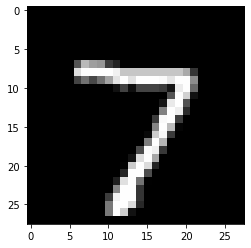

In [18]:
print(t_test_hot[0])
img = x_test[0,:].reshape(28,28)
plt.imshow(img, cmap='gray')
plt.show()

# 2. Building the network

In [19]:
# Activation Functions 
def sigmoid(inputs):
    return 1 / (1 + np.exp(-inputs))
def softmax(inputs):
    val = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
    return val/ np.sum(val, axis=1, keepdims=True)
# Loss function 
def log_loss(y_hat, y_target):
    y_hat = np.clip(y_hat, 1e-7, 1 - 1e-7)
    val = np.sum(y_hat * y_target,axis=1)
    return np.mean(-np.log(val))
# Gradient funcrtions for loss and activation 
def gradient_loss(y_hat, y_target):
    return y_hat - y_target
def gradient_sigmoid(layer, grads_in):
    return grads_in * layer.activation_output * (1 - layer.activation_output)
# Optimizer 
def optimizer(layer, lr):
    layer.weights = layer.weights -lr * layer.dw
    layer.biases = layer.biases -lr * layer.db
def mini_batch(X, y, batchSize):
	for i in np.arange(0, X.shape[0], batchSize):
		yield (X[i:i + batchSize], y[i:i + batchSize])

In [20]:
class layer():
    def __init__ (self, input_size, neuron_no):
        self.neuron_no = neuron_no
        self.weights = 0.1 * np.random.randn(input_size, neuron_no)
        self.biases = np.zeros((1, neuron_no))
    def forward_pass(self, inputs, activation = 'sigmoid'):
        self.inputs = inputs 
        self.outputs = np.dot(inputs, self.weights) + self.biases
        if activation == 'sigmoid': self.activation_output = sigmoid(self.outputs) 
        elif activation == 'softmax': self.activation_output = softmax(self.outputs)
    def backward_pass(self, grads_in):
        self.dw = np.dot(self.inputs.T, grads_in)
        self.db = np.sum(grads_in, axis=0, keepdims=True)
        self.grads = np.dot(grads_in, self.weights.T)

In [21]:
# Setting up the network 
input_layer = layer(neuron_no=300, input_size=784)
output_layer = layer(neuron_no=10, input_size=300)

In [22]:
# Taking very small segment of database to verify the structure of the network
X = x_train[:100].reshape(100,784)
Y = t_train_hot[:100].reshape(100,10)
X.shape, Y.shape

((100, 784), (100, 10))

In [24]:
# Trying out the network with sample input
input_layer.forward_pass(inputs=X)
output_layer.forward_pass(inputs=input_layer.activation_output, activation='softmax')

print('         ### Nerwork Summary ###')
print('Input shape                    :', X.shape)
print("Output shape first layer       :",input_layer.outputs.shape)
print("Output shape Sigmoid Activation:", input_layer.activation_output.shape)
print("Output shape hidden layer      :",output_layer.outputs.shape)
print("Output shape output layer.     :",output_layer.activation_output.shape)

         ### Nerwork Summary ###
Input shape                    : (100, 784)
Output shape first layer       : (100, 300)
Output shape Sigmoid Activation: (100, 300)
Output shape hidden layer      : (100, 10)
Output shape output layer.     : (100, 10)


In [25]:
loss = log_loss(output_layer.activation_output, Y)
loss

2.3925560743214747

In [31]:
# Back propagate to get the local gradients of each functions 
dL = gradient_loss(output_layer.activation_output, Y)
output_layer.backward_pass(dL)
d_sig = gradient_sigmoid(input_layer, output_layer.grads)
input_layer.backward_pass(d_sig)


print('      # Backword Propagation.  ')
print('Derivative shape of Loss         :', dL.shape)
print('Derivative shape of hidden layer :',output_layer.grads.shape)
print('Derivative shape of sigmoid layer:', d_sig.shape)
print('Derivative shape of input layer  :', input_layer.grads.shape)

      # Backword Propagation.  
Derivative shape of Loss         : (100, 10)
Derivative shape of hidden layer : (100, 300)
Derivative shape of sigmoid layer: (100, 300)
Derivative shape of input layer  : (100, 784)


In [32]:
lr = 0.01 
epochs = 20
batch_size = 50
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []

# Setting up the network 
input_layer = layer(neuron_no=300, input_size=784)
output_layer = layer(neuron_no=10, input_size=300)

for epoch in np.arange(0, epochs):
  trainLoss = []
  trainAcc = []
  valLoss = []
  valAcc = []
  for (miniX, miniY) in mini_batch(x_train, t_train_hot, batch_size):

    # Forward Pass
    input_layer.forward_pass(inputs=miniX, activation='sigmoid')
    output_layer.forward_pass(inputs=input_layer.activation_output, 
                             activation='softmax')
    # Calculate Loss 
    loss = log_loss(output_layer.activation_output, miniY)
    # loss = np.sum(err ** 2)
    trainLoss.append(loss)
    
    predictions = np.argmax(output_layer.activation_output, axis=1)
    if len(miniY.shape) == 2:
        y = np.argmax(miniY, axis=1)
    accuracy = np.mean(predictions==y)
    trainAcc.append(accuracy)

    # Backward pass 
    dL = gradient_loss(output_layer.activation_output, miniY)
    output_layer.backward_pass(dL)
    d_sig = gradient_sigmoid(input_layer, output_layer.grads)
    # print(d_sig)
    input_layer.backward_pass(d_sig)

    # update weights and biases 
    optimizer(input_layer, lr)
    optimizer(output_layer, lr)
  for (miniX, miniY) in mini_batch(x_test, t_test_hot, batch_size):

    # Forward Pass
    input_layer.forward_pass(inputs=miniX, activation='sigmoid')
    output_layer.forward_pass(inputs=input_layer.activation_output, 
                             activation='softmax')
    # Calculate Loss 
    loss = log_loss(output_layer.activation_output, miniY)
    # loss = np.sum(err ** 2)
    valLoss.append(loss)

    predictions = np.argmax(output_layer.activation_output, axis=1)
    if len(miniY.shape) == 2:
        y = np.argmax(miniY, axis=1)
    accuracy = np.mean(predictions==y)
    valAcc.append(accuracy)

  # print('epoch',epoch,'train loss:', np.average(trainLoss), "Val loss:", np.average(valLoss))
  print(f'epoch {epoch}, train loss: {np.average(trainLoss):.3f}, val loss:{np.average(valLoss):.3f}, train acc:{np.average(trainAcc):.3f}, val acc:{np.average(valAcc):.3f}')
  training_loss.append(np.average(trainLoss))
  validation_loss.append(np.average(valLoss))
  training_accuracy.append(np.average(trainAcc))
  validation_accuracy.append(np.average(valAcc))



epoch 0, train loss: 0.392, val loss:0.250, train acc:0.890, val acc:0.923
epoch 1, train loss: 0.201, val loss:0.181, train acc:0.942, val acc:0.946
epoch 2, train loss: 0.147, val loss:0.143, train acc:0.958, val acc:0.958
epoch 3, train loss: 0.116, val loss:0.120, train acc:0.967, val acc:0.963
epoch 4, train loss: 0.095, val loss:0.106, train acc:0.973, val acc:0.968
epoch 5, train loss: 0.081, val loss:0.096, train acc:0.977, val acc:0.971
epoch 6, train loss: 0.069, val loss:0.090, train acc:0.981, val acc:0.973
epoch 7, train loss: 0.060, val loss:0.085, train acc:0.983, val acc:0.974
epoch 8, train loss: 0.053, val loss:0.081, train acc:0.986, val acc:0.976
epoch 9, train loss: 0.047, val loss:0.078, train acc:0.987, val acc:0.977
epoch 10, train loss: 0.041, val loss:0.075, train acc:0.989, val acc:0.977
epoch 11, train loss: 0.037, val loss:0.073, train acc:0.991, val acc:0.978
epoch 12, train loss: 0.033, val loss:0.072, train acc:0.992, val acc:0.978
epoch 13, train loss: 

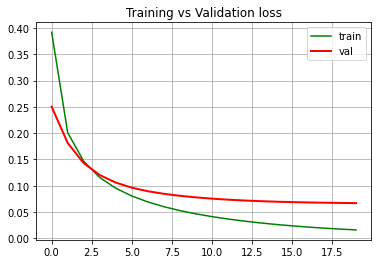

In [33]:
plt.title('Training vs Validation loss')
plt.plot(training_loss, color='g', label='train' )
plt.plot(validation_loss, linewidth=2, color='r', label='val')
plt.legend()
plt.grid()
plt.show()

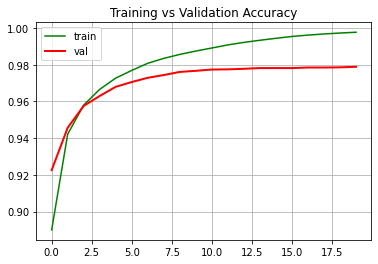

In [34]:
plt.title('Training vs Validation Accuracy')
plt.plot(training_accuracy,color='g', label='train')
plt.plot(validation_accuracy,linewidth=2, color='r', label='val')
plt.legend()
plt.grid()
plt.show()